<a href="https://colab.research.google.com/github/Arsenii-Girchenko/Colab/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D0%BE%D0%B5_%D0%94%D0%97_FlowerClassification_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ. Классификация цветов

### Продолжим работать с [Датасетом](https://www.kaggle.com/alxmamaev/flowers-recognition ) для классификации цветов (тюльпан, ромашка, подсолнух, роза, одуванчик).


### Загрузите папку с картинками на свой гугл-диск, и подключите диск к коллабу.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Подготовка датасета и функции для обучения

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/gdrive/MyDrive/Flowers/Flower_recognition/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

('/content/gdrive/MyDrive/Flowers/Flower_recognition/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


### Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32 # размер батча
lr = 0.001 # learning rate

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

In [ ]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False

# Домашнее задание

В домашнем задании попробуем обучить еще одну сверточную архитектуру.

1) Разберите более детально код выше (или код с практики, они идентичны). Запустите весь код в этом ноутбуке.


2) Посмотрите как задаются [модели сверточных сетей в PyTorch](https://pytorch.org/vision/stable/models.html), выберите одну модель из списка:

*   alexnet
*   vgg16
*   mobilenet_v2
*   mobilenet_v3_small
*   densenet

3) Дообучите выбранную модель для задачи классификации цветов, по аналогии с тем, как мы дообучали resnet18 на занятии. Чтобы это сделать замените ____ в ячейках ниже на код. Где-то надо вставить нужную переменную, где-то прописать константу. Главное не пугайтесь! Аналогичный код можно найти в ноутбуке с практикой ;)

4) Если вам интересно, прочитайте дополнительно про эти архитектуры. Можно почитать [здесь (на английском)](https://medium.com/@fransiska26/the-differences-between-inception-resnet-and-mobilenet-e97736a709b0) или [здесь (на русском)](https://habr.com/ru/company/nix/blog/430524/)

**Совет 1:** загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) должна быть такой: drive/MyDrive/flowers

**Совет 2:** обязательно подключите аппаратный ускоритель (GPU) к среде выполнения, чтобы вычисления были. В меню сверху: Среда выполнения -> Сменить среду выполнения



In [ ]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model = torchvision.models.mobilenet_v3_small(pretrained=True)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента

In [ ]:
model.classifier = nn.Linear(576,5)

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [ ]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=5) # запускаем обучение, задаем количество эпох

100%|██████████| 104/104 [09:22<00:00,  5.41s/it]


[training] Epoch: 0.00. Loss: 0.93. Accuracy: 71.00% 


100%|██████████| 32/32 [03:11<00:00,  5.97s/it]


[validation] Epoch: 0.00. Loss: 0.58. Accuracy: 82.10% 


100%|██████████| 104/104 [00:15<00:00,  6.92it/s]


[training] Epoch: 1.00. Loss: 0.75. Accuracy: 76.53% 


100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[validation] Epoch: 1.00. Loss: 0.53. Accuracy: 82.85% 


100%|██████████| 104/104 [00:15<00:00,  6.84it/s]


[training] Epoch: 2.00. Loss: 0.67. Accuracy: 79.24% 


100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[validation] Epoch: 2.00. Loss: 0.50. Accuracy: 83.80% 


100%|██████████| 104/104 [00:15<00:00,  6.77it/s]


[training] Epoch: 3.00. Loss: 0.61. Accuracy: 80.76% 


100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[validation] Epoch: 3.00. Loss: 0.48. Accuracy: 84.45% 


100%|██████████| 104/104 [00:15<00:00,  6.84it/s]


[training] Epoch: 4.00. Loss: 0.57. Accuracy: 81.75% 


100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

[validation] Epoch: 4.00. Loss: 0.47. Accuracy: 84.84% 


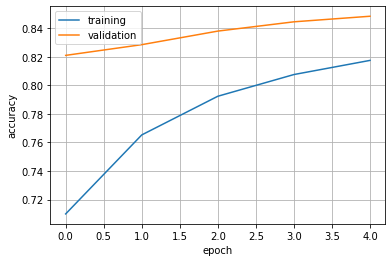

In [ ]:
from matplotlib import pyplot as plt
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()